In [1]:
import pandas as pd
import numpy as np
import os 
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from copy import deepcopy

base_path = '/Users/freezylex/Documents/course_work/'

### USDRUB

In [2]:
usdrub = pd.read_excel(os.path.join(base_path, 'data/raw_data/usdrub.xlsx'))[::-1].reset_index(drop=True)
usdrub = usdrub[['data', 'curs']]
usdrub.columns = ['Date', 'USDRUB_CBR']
usdrub['Date'] = pd.to_datetime(usdrub['Date'], format='%Y-%m-%d')
#usdrub.set_index('Date', inplace=True)
usdrub

,Date,USDRUB_CBR
0,2015-03-02,62.2248
1,2015-03-03,62.2248
2,2015-03-04,62.3649
3,2015-03-05,61.8745
4,2015-03-06,61.8457
...,...,...
238,2016-02-13,79.4951
239,2016-02-16,77.7792
240,2016-02-17,76.2450
241,2016-02-18,77.8503


### Brent

In [3]:
brent = pd.read_excel(os.path.join(base_path, 'data/raw_data/brent.xlsx'))[::-1].reset_index(drop=True)
brent.columns = ['Date', 'Brent_price']
brent['Date'] = pd.to_datetime(brent['Date'], format='%Y-%m-%d')
#brent.set_index('Date', inplace=True)
brent

,Date,Brent_price
0,2015-03-02,59.54
1,2015-03-03,61.02
2,2015-03-04,60.55
3,2015-03-05,60.48
4,2015-03-06,59.73
...,...,...
248,2016-02-15,33.39
249,2016-02-16,32.18
250,2016-02-17,34.50
251,2016-02-18,34.28


## Connection of USDRUB and Brent

- it is very important to show how oil prices (in particular, Brent) influence Russian currency.

In [4]:
info = brent.merge(usdrub, on='Date').set_index('Date').loc['2015-06-01':]
np.corrcoef(info['Brent_price'], info['USDRUB_CBR'])

array([[ 1.        , -0.95847038],
       [-0.95847038,  1.        ]])

The correlation between them is more than obvious. It is mostly due to the budget rules introduced in Russia.

It is also important to understand that the exogenous variable is Oil price, whereas USDRUB changes depending on it. However, since all bonds are traded in RUR, RVI index is calculated based on MOEX stocks also in RUR, and the value of the CDS contract is also in currency, later on we will use in the model USDRUB variable, not Brent.

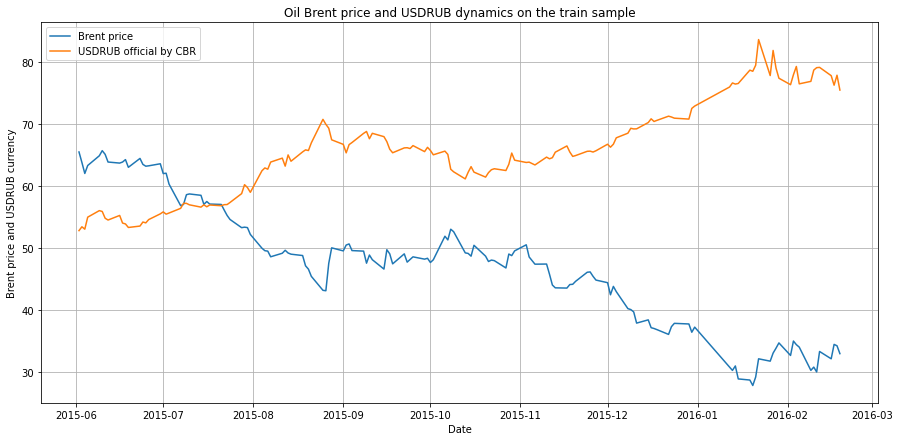

In [6]:
info.reset_index(inplace=True)
fig, ax = plt.subplots(figsize=(15, 7))
sns.lineplot(x = info['Date'], y = info['Brent_price'], label='Brent price')
sns.lineplot(x = info['Date'], y = info['USDRUB_CBR'], label='USDRUB official by CBR')
plt.ylabel('Brent price and USDRUB currency')
plt.title('Oil Brent price and USDRUB dynamics on the train sample')
plt.grid()
plt.savefig(os.path.join(base_path, 'graphs/USDRUB_Brent.png'), dpi=300)

No doubt that both variables are not stationary. However, after de-trending it is mostly likely that they will be stationary. It can checked using ADF/KPSS test.

On the graph above 3 periods can be observed:
- Until 2015-08-03 oil prices were going down and, therefore, Russian ruble also devaluing. After that, some period of stabilization happened, when oil price and USDRUB did not change until the beginning of the 2016 (2016-01-04). At that time, oil prices started going down again - https://www.vedomosti.ru/business/articles/2016/01/13/623758-padenie-neftyanih-kotirovok?utm_source=yxnews&utm_medium=desktop&utm_referrer=https%3A%2F%2Fyandex.ru%2Fnews%2Fsearch%3Ftext%3D 
Due to market glut and high oil production, oil prices have been declining for about 18 months. As the dollar has risen and stock markets around the world have fallen, the question has arisen as to whether demand will rise fast enough to outweigh supply. News: https://ria.ru/20160112/1358734018.html?utm_source=yxnews&utm_medium=desktop&utm_referrer=https%3A%2F%2Fyandex.ru%2Fnews%2Fsearch%3Ftext%3D
- This shock was happening until mid January, when an emergency OPEC meeting was initiated: oil prices literally soared after Russian Energy Minister A. Novak said that OPEC and other oil producers would meet in February to discuss reducing production levels. News: http://www.finmarket.ru/analytics/4208184?utm_source=yxnews&utm_medium=desktop&utm_referrer=https%3A%2F%2Fyandex.ru%2Fnews%2Fsearch%3Ftext%3D 

#### Upload target

In [6]:
rates = pd.read_excel(base_path + 'data/final_target.xlsx',
                      index_col = 'Date', parse_dates=True)
rates.drop(columns=['SU26217RMFS', 'SU26218RMFS'], inplace=True)
rates.head(2)

,SU26214RMFS,SU26215RMFS,SU26216RMFS,SU26203RMFS,SU26204RMFS,SU26205RMFS,SU26206RMFS,SU26207RMFS,SU26208RMFS,SU26209RMFS,SU26210RMFS,SU26211RMFS,SU26212RMFS
Date,,,,,,,,,,,,,
2015-03-02,-71.009402,-16.198293,-51.672678,213.214039,8.877833,-69.514138,81.363229,81.611366,-44.294101,-46.555882,-65.581271,-32.632524,103.025743
2015-03-03,7.255880,45.041981,17.967756,263.188637,62.406383,10.363783,125.481830,112.795674,22.874165,26.012453,9.625523,34.752162,129.932953


In [7]:
def make_plot_for_gen(df, factor, factor_col, hue_date_1=None, hue_date_2 = None):
    fig, ax = plt.subplots(2, 7, figsize=(30, 20))
    min_ = df.values.ravel().min()
    max_ = df.values.ravel().max()
    if hue_date_1:
        h = pd.Series(index = factor.index, data = np.zeros(shape=factor.shape[0]))
        h.loc[:hue_date_1] = 1
        h.loc[hue_date_2:] = 2
    else:
        h = None
    i = 0
    for col in df.columns:
        if i < 7:
            sns.scatterplot(x = factor[factor_col],y = df[col], ax = ax[0, i], hue = h)
            ax[0, i].set_ylim([min_ - 0.1, max_ + 0.1])
        else:
            sns.scatterplot(x = factor[factor_col], y = df[col], ax = ax[1, i-7], hue = h)
            ax[1, i-7].set_ylim([min_ - 0.1, max_ + 0.1])
        i += 1

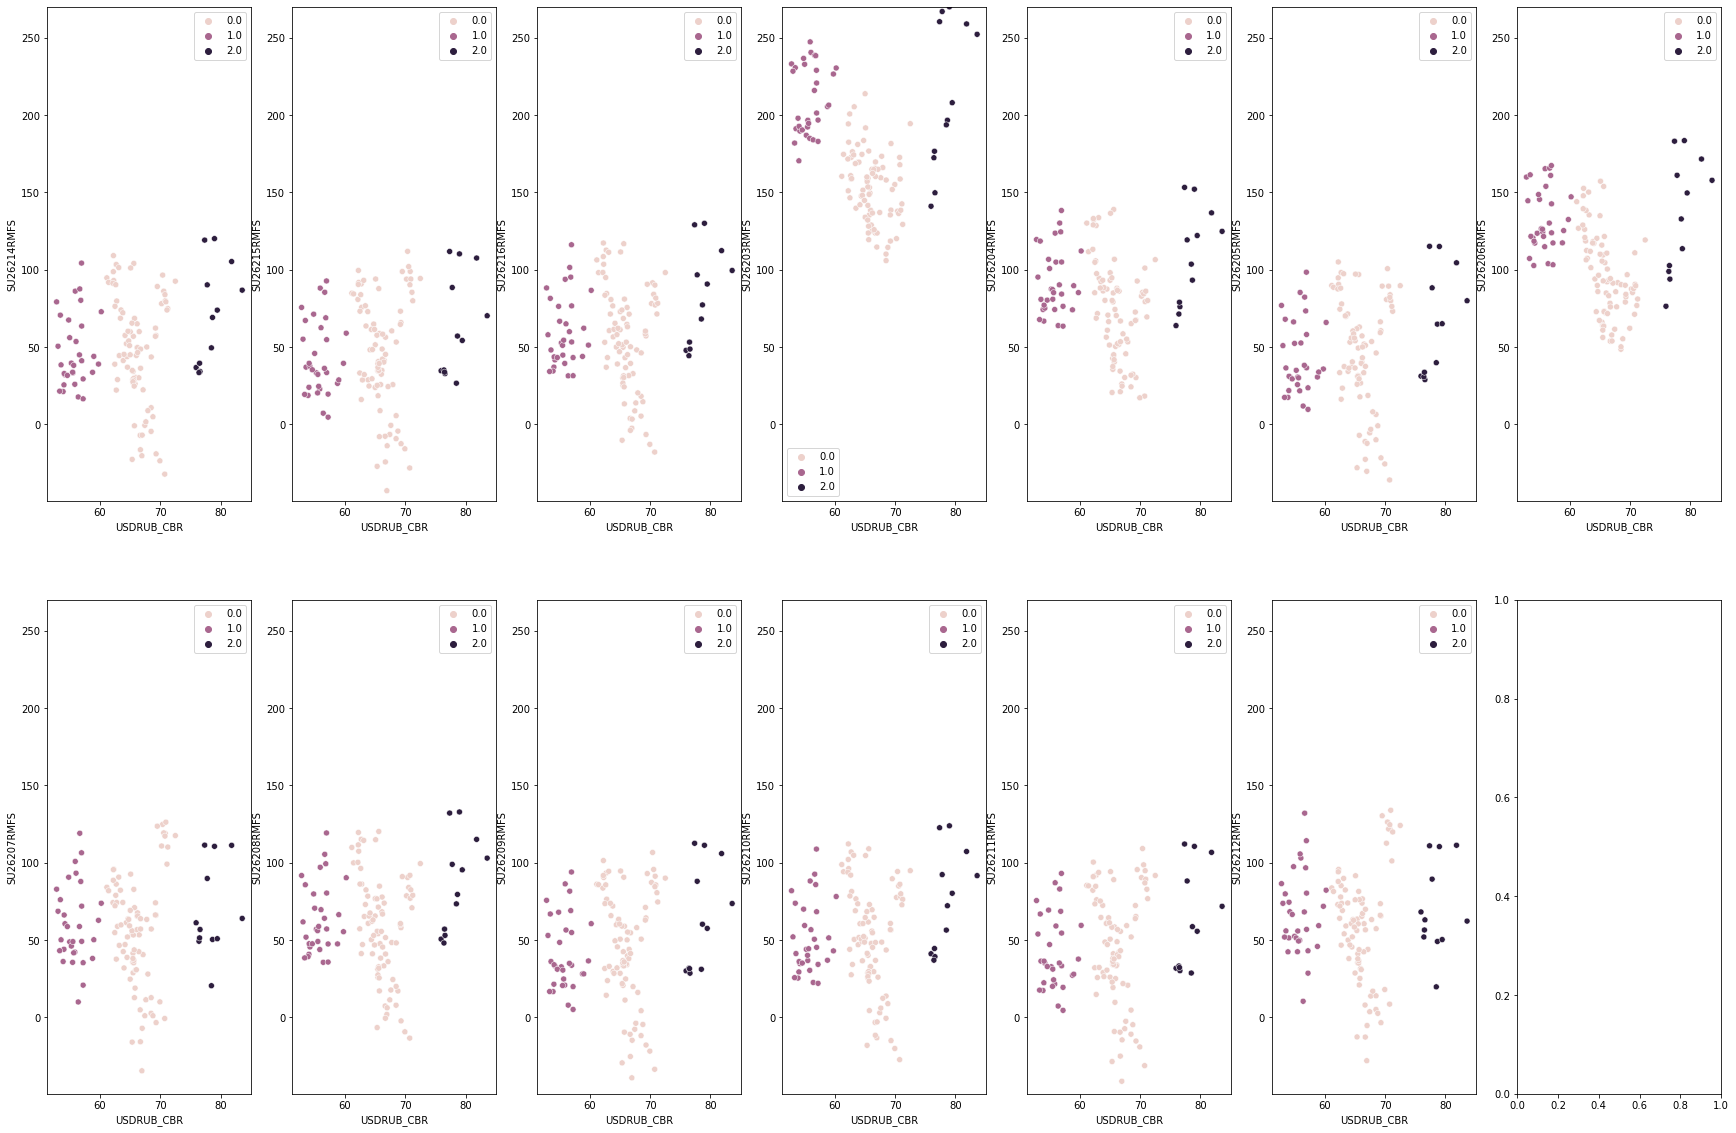

In [8]:
usdrub.set_index('Date', inplace=True)
make_plot_for_gen(rates.loc['2015-06-01':'2016-01'], 
                  usdrub.loc['2015-06-01':'2016-01'], 'USDRUB_CBR', '2015-08-03','2016-01-04')

As we have mentioned earlier, three different regimes can be observed. Due to the arguments above, we consider necessary to introduce 2 dummy variables:
- the first dummy variable will indicate the first period of oil prices fall: until 2015-08-03
- the second one will depict the oil price shock in January, 2016. It will be made in the RVI notebook.

In [9]:
usdrub['dummy_1_oil_shock'] = 0
usdrub.loc[:'2015-08-03', 'dummy_1_oil_shock'] = 1
usdrub['USDcoef_oil_shock_1'] = usdrub['USDRUB_CBR'] * usdrub['dummy_1_oil_shock']
usdrub

,USDRUB_CBR,dummy_1_oil_shock,USDcoef_oil_shock_1
Date,,,
2015-03-02,62.2248,1,62.2248
2015-03-03,62.2248,1,62.2248
2015-03-04,62.3649,1,62.3649
2015-03-05,61.8745,1,61.8745
2015-03-06,61.8457,1,61.8457
...,...,...,...
2016-02-13,79.4951,0,0.0000
2016-02-16,77.7792,0,0.0000
2016-02-17,76.2450,0,0.0000


In [10]:
usdrub.to_csv(os.path.join(base_path, 'data/metrics_final/usdrub.csv'))